In [ ]:
from google.colab import drive
import os

# set path to project folder
gdrive_path='/content/gdrive/MyDrive/1-university/masters/2-semester/in2390_adl4cv' # Luca's Path
#gdrive_path='/content/gdrive/MyDrive/Uni/adl4vc' # Luis' Path

# mount Google Drive
drive.mount('/content/gdrive', force_remount=True)

# navigate to Google Drive folder
os.chdir(gdrive_path)

# check that we are in the right folder
print(sorted(os.listdir()))

Mounted at /content/gdrive
['OpenNeRF.pdf', 'PeRFception.pdf', 'SegAnyGAussians', 'colmap-3.8.tar.gz', 'colmap_colab', 'gaussian-splatting', 'libglvnd', 'miniconda.sh', 'nerf_segmentation', 'opennerf', 'presentation.pptx', 'slides']


# 3D Reconstruction using Standard Gaussian Splatting

## Setup

We will use `nerfstudio` to train, run, and visualize our results. Make sure to have the following repository structure established:
```
adl4vc  
|_ nerf_segmentation  
    |_ data  
        |_ lerf  
        |_ replica  
|_ opennerf
```

Let's start with some general dependencies such as `tinycuda`, `colmap`, and `torch`.

In [ ]:
!python -m pip install --upgrade pip
!python -m pip install pytorch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2 pytorch-cuda=12.1 -c pytorch -c nvidia
!python -m pip install ninja git+https://github.com/NVlabs/tiny-cuda-nn/#subdirectory=bindings/torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'pytorch'
  Cloning https://github.com/NVlabs/tiny-cuda-nn/ to /tmp/pip-req-build-l874fs4h
  Running command git clone --filter=blob:none --quiet https://github.com/NVlabs/tiny-cuda-nn/ /tmp/pip-req-build-l874fs4h
  Resolved https://github.com/NVlabs/tiny-cuda-nn/ to commit 2ec562e853e6f482b5d09168705205f46358fb39
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 6.8 MB/s eta 0:00:00
  Created wheel for tinycudann: filename=tinycudann-1.7-cp310-cp310-linux_x86_64.whl size=30358239 sha256=01e52b937a522df626bc307fbc6fe4c6d73ac065ec663e0146970262a3664262
  Stored in directory: /tmp/pip

In [ ]:
!pip install tensorflow-gpu==2.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 44.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: 

In [ ]:
!python -m pip install nerfstudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of imageio to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of nuscenes-devkit to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.1/108.1 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.2/570.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

Once we have installed all required dependencies, we can make use of `nerfstudio`'s implementation of Gaussian Splatting. It is called `splatfacto` to delineate from the original Gaussian Splatting paper. Let's start by training it scenes from Replica! With a T4-GPU, this will take ~35min for a single scene.

## Run Training

In [ ]:
!ns-train nerfacto --viewer.make-share-url True --data /content/gdrive/MyDrive/1-university/masters/2-semester/in2390_adl4cv/nerf_segmentation/data/nerfstudio_/replica_office0

Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1006, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 688, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/usr/local/lib/python3.10/dist-packages/torchgen/model.py", line 1698, in <module>
    class Annotation:
  File "/usr/lib/python3.10/dataclasses.py", line 1175, in wrap
    return _process_class(cls, init, repr, eq, order, unsafe_hash,
  File "/usr/lib/python3.10/dataclasses.py", line 1044, in _process_class
    _set_new_attribute(cls, '__repr__', _repr_fn(flds, globals))
  File "/usr/lib/python3.10/dataclasses.py", line 588, in _repr_fn
    fn = _create_fn('__repr__',
  File "/usr/lib/python3.10/dataclasses.py", line 432, in _create_fn
    exec(txt, globals, ns)
  File "<string>", 

## Export Results

In [ ]:
!ns-export gaussian-splat --load-config /content/gdrive/MyDrive/1-university/masters/2-semester/in2390_adl4cv/nerf_segmentation/outputs/replica_office0/splatfacto/2024-05-13_211923/config.yml --output-dir /content/gdrive/MyDrive/1-university/masters/2-semester/in2390_adl4cv/nerf_segmentation/outputs/replica_office0/splatfacto/2024-05-12_211923/

2024-05-13 20:34:16.134451: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2024-05-13 20:34:16.134497: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[20:34:29] Auto image downscale factor of 1                                                 ]8;id=912482;file:///usr/local/lib/python3.10/dist-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=70015;file:///usr/local/lib/python3.10/dist-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#484\484]8;;\
Traceback (most recent call last):
  File "/usr/local/bin/ns-export", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/d

[Open3D WARNING] Read PLY failed: unable to open file: /content/gdrive/MyDrive/1-university/masters/2-semester/in2390_adl4cv/nerf_segmentation/outputs/replica_office0/splatfactor/2024-05-13_211923/splat.ply


RPly: Unable to open file


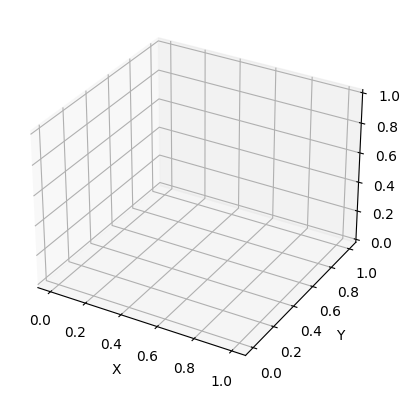

In [ ]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the .ply file
ply_file_path = '/content/gdrive/MyDrive/1-university/masters/2-semester/in2390_adl4cv/nerf_segmentation/outputs/replica_office0/splatfactor/2024-05-13_211923/splat.ply'
pcd = o3d.io.read_point_cloud(ply_file_path)

# Convert the point cloud to a numpy array
points = np.asarray(pcd.points)

# Plot the point cloud using matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1, c='b', marker='o')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [ ]:
import os

# Verify if the file path exists
ply_file_path = '/content/gdrive/MyDrive/1-university/masters/2-semester/in2390_adl4cv/nerf_segmentation/outputs/replica_office0/splatfacto/2024-05-13_211923/splat.ply'
if os.path.exists(ply_file_path):
    print("File exists.")
else:
    print("File does not exist.")

# List all files in the directory to confirm the file name and path
directory_path = os.path.dirname(ply_file_path)
files = os.listdir(directory_path)
print("Files in the directory:", files)


File exists.
Files in the directory: ['config.yml', 'dataparser_transforms.json', 'nerfstudio_models', 'splat.ply']


## Understanding the PLY File Format from NeRFStudio

This documentation explains the structure and properties of the PLY file generated using NeRFStudio's `ns-export splatfacto` function. This PLY file represents a 3D point cloud derived from a Neural Radiance Field (NeRF).

The primary element in the PLY file is `vertex`, which defines each point in the point cloud. Each vertex has several properties associated with it:

### Opacity

- `opacity`: Represents the transparency of the vertex, with values ranging from 0 (completely transparent) to 1 (completely opaque).

### Transformation Properties

- `scale_0`, `scale_1`, `scale_2`: Scaling factors for the vertex in the x, y, and z dimensions, respectively. These adjust the size of the Gaussian splats.
- `rot_0`, `rot_1`, `rot_2`, `rot_3`: Components of a quaternion representing the rotation of the vertex in 3D space.



### Spatial Properties

- `x`, `y`, `z`: Coordinates of the vertex in 3D space.
- `nx`, `ny`, `nz`: Components of the normal vector, indicating the surface orientation at the vertex.

### Color Properties

- `f_dc_0`, `f_dc_1`, `f_dc_2`: Diffuse color components of the vertex, likely in RGB format.
  - `f_dc_0`: Red component
  - `f_dc_1`: Green component
  - `f_dc_2`: Blue component

### Additional Feature Properties

- `f_rest_0` to `f_rest_44`: Spherical Harmonics parameters.

### Displaying Features from PLY File

In [ ]:
!python -m pip install plyfile

In [ ]:
import os
import pandas as pd
from plyfile import PlyData
import torch
from IPython.display import display

# Specify the path to your .ply file
ply_file_path = '/content/gdrive/MyDrive/1-university/masters/2-semester/in2390_adl4cv/nerf_segmentation/outputs/replica_office0/splatfacto/2024-05-13_211923/splat.ply'

# Verify if the file exists before trying to read it
if os.path.exists(ply_file_path):
    # Load the .ply file
    ply_data = PlyData.read(ply_file_path)

    # Extract the vertex data
    vertex_data = ply_data['vertex']
    vertex_df = pd.DataFrame(vertex_data.data)

    # Display the dataframe to verify
    display(vertex_df)

    # Remove columns with zero variance
    non_zero_variance_df = vertex_df.loc[:, vertex_df.var() != 0]

    # Convert DataFrame to numpy array for processing
    features = non_zero_variance_df.values

    # Normalize the features
    features_mean = features.mean(axis=0)
    features_std = features.std(axis=0)

    # Add a small epsilon value to std to avoid division by zero
    epsilon = 1e-8
    normalized_features = (features - features_mean) / (features_std + epsilon)

    # Convert normalized features to a PyTorch tensor
    input_tensor = torch.tensor(normalized_features, dtype=torch.float32)

    # Print the shape of the tensor to verify
    print("Shape of input tensor:", input_tensor.shape)
else:
    print("The file does not exist. Please check the file path.")

,x,y,z,nx,ny,nz,f_dc_0,f_dc_1,f_dc_2,f_rest_0,...,f_rest_43,f_rest_44,opacity,scale_0,scale_1,scale_2,rot_0,rot_1,rot_2,rot_3
0,-0.586364,-2.030792,3.316855,0.0,0.0,0.0,0.178468,0.896800,0.374212,0.000000,...,0.000000,0.000000,-2.197225,-1.516485,-1.516485,-1.516485,0.535505,0.774932,-0.335693,-0.005054
1,4.515545,-4.247341,3.860137,0.0,0.0,0.0,0.933382,0.969690,0.122286,0.000000,...,0.000000,0.000000,-2.197225,-2.101660,-2.101660,-2.101660,0.141955,-0.303761,0.450463,-0.827442
2,0.832096,-1.623523,3.089750,0.0,0.0,0.0,0.192759,0.674811,0.188885,0.000000,...,0.000000,0.000000,-2.197225,-1.612986,-1.612986,-1.612986,0.728750,0.617235,-0.277117,0.105590
3,-1.931803,-3.835114,4.102695,0.0,0.0,0.0,0.437477,0.355583,0.922609,0.000000,...,0.000000,0.000000,-2.197225,-1.533376,-1.533376,-1.533376,0.117810,0.863854,-0.471031,0.134190
4,-3.911819,-3.363445,2.025201,0.0,0.0,0.0,0.137895,0.040298,0.812131,0.000000,...,0.000000,0.000000,-2.197225,-1.831025,-1.831025,-1.831025,-0.255625,0.246248,-0.402120,-0.843989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149583,-1.318139,0.372601,0.308178,0.0,0.0,0.0,-1.058594,-1.006405,-0.816536,-0.159313,...,-0.007029,-0.002059,12.180046,-8.041290,-5.630896,-4.966950,0.269389,-0.624547,-0.376930,-0.910886
149584,1.313110,0.670244,-0.232932,0.0,0.0,0.0,-1.868465,-1.801147,2.641839,0.000000,...,0.132510,0.001263,-1.631180,-6.694486,-10.765563,-4.485522,-0.051159,0.509315,-1.240515,0.004626
149585,1.389073,0.108089,-0.452224,0.0,0.0,0.0,-1.797254,-1.800059,2.646681,0.000000,...,-0.159098,-0.006908,-1.063409,-4.645093,-7.197409,-5.825305,-0.320300,0.813884,-0.688510,0.156729
149586,1.383839,0.130209,-0.417365,0.0,0.0,0.0,-1.868465,-1.801147,11.330553,0.000000,...,-0.241843,-0.006567,-1.421703,-7.286758,-7.073628,-4.249224,-0.073704,0.332876,-1.834800,-0.101012


Shape of input tensor: torch.Size([149588, 59])


# 3D Segmentation using SegmentAnyGAussians (SAGA)

## Setup

Our first approach for semantic segmentation will be inspired by SegmentAnyGAussians (SAGA). We'll try to understand, how we have to encode/postprocess the output in order to make it compatible with the segmentation pipeline.

In [ ]:
%cd {gdrive_path}
!git clone https://github.com/Jumpat/SegAnyGAussians.git

/content/gdrive/MyDrive/1-university/masters/2-semester/in2390_adl4cv
Cloning into 'SegAnyGAussians'...
remote: Enumerating objects: 1707, done.
remote: Counting objects: 100% (1707/1707), done.
remote: Compressing objects: 100% (753/753), done.
remote: Total 1707 (delta 942), reused 1687 (delta 934), pack-reused 0
Receiving objects: 100% (1707/1707), 27.51 MiB | 15.90 MiB/s, done.
Resolving deltas: 100% (942/942), done.
Updating files: 100% (3197/3197), done.


Next, we will install all dependencies from the repository.

In [ ]:
# 31mins - required for feature extraction and Segment Anything Masks
!pip install -q 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 952.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


**Important:** Before executing the following cell, you have to go to the SegAnyGAussians repository and replace the content of `.gitmodules` with the following:
```
[submodule "third_party/kmeans_pytorch"]
	path = third_party/kmeans_pytorch
	url = https://github.com/subhadarship/kmeans_pytorch.git
[submodule "third_party/segment-anything"]
	path = third_party/segment-anything
	url = https://github.com/facebookresearch/segment-anything.git

```

We install all subdirectories that are required by SAGA.

In [ ]:
%cd {gdrive_path}/SegAnyGAussians
!pip install -q plyfile
!pip install -q {gdrive_path}/SegAnyGAussians/submodules/diff-gaussian-rasterization
!pip install -q {gdrive_path}/SegAnyGAussians/submodules/diff-gaussian-rasterization_contrastive_f
!pip install -q {gdrive_path}/SegAnyGAussians/submodules/simple-knn
!git submodule init
!git submodule sync
!git submodule update
!pip install -q {gdrive_path}/SegAnyGAussians/third_party/segment-anything
!pip install -q {gdrive_path}/SegAnyGAussians/third_party/kmeans_pytorch

/content/gdrive/MyDrive/1-university/masters/2-semester/in2390_adl4cv/SegAnyGAussians
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
Synchronizing submodule url for 'third_party/kmeans_pytorch'
Synchronizing submodule url for 'third_party/segment-anything'
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


Next, we install all packages that are required for colmap. Note that for colmap we explicitly need cuda11.x!

In [ ]:
!sudo apt-get install cuda-cudart-11-8

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cuda-toolkit-11-8-config-common cuda-toolkit-11-config-common
The following NEW packages will be installed:
  cuda-cudart-11-8 cuda-toolkit-11-8-config-common
  cuda-toolkit-11-config-common
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 198 kB of archives.
After this operation, 938 kB of additional disk space will be used.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  cuda-toolkit-11-config-common 11.8.89-1 [16.4 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  cuda-toolkit-11-8-config-common 11.8.89-1 [16.3 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  cuda-cudart-11-8 11.8.89-1 [165 kB]
Fetched 198 kB in 0s (1,348 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-l

In [ ]:
%cd {gdrive_path}
!apt-get install \
    ninja-build \
    build-essential \
    libboost-program-options-dev \
    libboost-filesystem-dev \
    libboost-graph-dev \
    libboost-system-dev \
    libeigen3-dev \
    libflann-dev \
    libfreeimage-dev \
    libmetis-dev \
    libgoogle-glog-dev \
    libgtest-dev \
    libsqlite3-dev \
    libglew-dev \
    qtbase5-dev \
    libqt5opengl5-dev \
    libcgal-dev \
    libceres-dev
!apt-get install xvfb
# libglvnd is needed for COLMAP to run on Google Colab (https://github.com/colmap/colmap/issues/1271#issuecomment-931900582)
!git clone https://github.com/NVIDIA/libglvnd
%cd {gdrive_path}/libglvnd
!apt-get install libxext-dev libx11-dev x11proto-gl-dev
!apt-get install autoconf automake libtool
!apt-get install libffi-dev
!./autogen.sh
!./configure
!make -j4
!make install
# Download and extract the pre-compiled COLMAP library
%cd {gdrive_path}
!gdown 1PyyNKY2mt4dHlYN5WcPnvWdV2nufQru1
!tar -C /usr -zxf colmap-3.8.tar.gz
# Install other Python libraries for the data preparation scripts
!pip install \
    addict \
    k3d \
    opencv-python-headless \
    pillow \
    plotly \
    pyyaml \
    trimesh
!git clone https://github.com/allenbijo/colmap_colab.git
%cd {gdrive_path}/colmap_colab

/content/gdrive/MyDrive/1-university/masters/2-semester/in2390_adl4cv
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
libboost-filesystem-dev is already the newest version (1.74.0.3ubuntu7).
libboost-filesystem-dev set to manually installed.
libboost-program-options-dev is already the newest version (1.74.0.3ubuntu7).
libboost-program-options-dev set to manually installed.
libboost-system-dev is already the newest version (1.74.0.3ubuntu7).
libboost-system-dev set to manually installed.
libboost-graph-dev is already the newest version (1.74.0.3ubuntu7).
libboost-graph-dev set to manually installed.
libsqlite3-dev is already the newest version (3.37.2-2ubuntu0.3).
libsqlite3-dev set to manually installed.
The following additional packages will be installed:
  googletest libamd2 libbtf1 libcamd2 libccolamd2 libceres2 libcholmod3 libcolamd2 libcxsparse3
  libegl-dev libevdev2 libf

In [ ]:
!pip install torch==2.1.2+cu118 torchvision==0.16.2+cu118 torchaudio --extra-index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 63.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 54.3 MB/s et

In [ ]:
!python -m pip install git+https://github.com/NVlabs/tiny-cuda-nn/#subdirectory=bindings/torch

  Cloning https://github.com/NVlabs/tiny-cuda-nn/ to /tmp/pip-req-build-_r7l5mhn
  Running command git clone --filter=blob:none --quiet https://github.com/NVlabs/tiny-cuda-nn/ /tmp/pip-req-build-_r7l5mhn
  Resolved https://github.com/NVlabs/tiny-cuda-nn/ to commit 2ec562e853e6f482b5d09168705205f46358fb39
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Created wheel for tinycudann: filename=tinycudann-1.7-cp310-cp310-linux_x86_64.whl size=30358192 sha256=064928e18f14cbe1b8c9c0d801d783a73b9348362116eb7daab87d89dd25c866
  Stored in directory: /tmp/pip-ephem-wheel-cache-s_5606fw/wheels/32/d8/5e/dc94eca0794af9e09a6d97f19cf15dfe9bbbc4d56ae4db4aa2
Successfully built tinycudann


## Preprocessing

The Replica Dataset is initially not compatible with the SAGA training process. Each room/scene should adhere to the following file structure:
```
adl4vc  
|_ nerf_segmentation
    |_ data
        |_ replica  
            |_ room0
                |_ images
                    |_ 000001.jpg
                    |_ ...
                    |_ 000251.jpg
                |_ sparse
                    |_ 0
                        |_ cameras.bin
                        |_ images.bin
                        |_ points3D.bin
                        |_ project.ini
            |_ roomX
                |_ same structure as for room 0
```

In the default setting, Replica has the following structure:
```
adl4vc  
|_ nerf_segmentation
    |_ data
        |_ replica  
            |_ room0_mesh.ply
            |_ room0
                |_ results
                    |_ depth000001.png
                    |_ ...
                    |_ depth001999.png
                    |_ frame000001.jpg
                    |_ ...
                    |_ frame001999.jpg
            |_ roomX_mesh.ply
            |_ roomX
                |_ same structure as for room 0
            |_ cam_params.json
```

We can make use of the provided `convert.py`-script from the Gaussian Splatting repo to convert Replica into the desired representation.

In [ ]:
replica_path = os.path.join(gdrive_path, 'nerf_segmentation', 'data', 'replica')

In [ ]:
# 8h / scene
%cd {gdrive_path}/gaussian-splatting
!python convert.py -s {os.path.join(replica_path, 'office0')}

Streaming output truncated to the last 5000 lines.
Registering image #1699 (1942)

  => Image sees 375 / 380 points

Pose refinement report
----------------------
    Residuals : 828
   Parameters : 6
   Iterations : 6
         Time : 0.00740099 [s]
 Initial cost : 0.492739 [px]
   Final cost : 0.408894 [px]
  Termination : Convergence

  => Continued observations: 370
  => Added observations: 9

Bundle adjustment report
------------------------
    Residuals : 5712
   Parameters : 53
   Iterations : 4
         Time : 0.045512 [s]
 Initial cost : 0.341678 [px]
   Final cost : 0.34086 [px]
  Termination : Convergence

  => Merged observations: 134
  => Completed observations: 4
  => Filtered observations: 18
  => Changed observations: 0.045761

Bundle adjustment report
------------------------
    Residuals : 5442
   Parameters : 47
   Iterations : 2
         Time : 0.0255449 [s]
 Initial cost : 0.392472 [px]
   Final cost : 0.392057 [px]
  Termination : Convergence

  => Merged observa

Download the following [SAM Checkpoint](), save it as `sam_checkpoint.pth` and put it inside `SegAnyGAussians/dependencies/`.

In [ ]:
%cd {gdrive_path}/SegAnyGAussians
!python extract_features.py --image_root {gdrive_path}/nerf_segmentation/data/replica/office0 --sam_checkpoint_path {gdrive_path}/SegAnyGAussians/dependencies/sam_checkpoint.pth

/content/gdrive/MyDrive/1-university/masters/2-semester/in2390_adl4cv/SegAnyGAussians
Initializing SAM...
Extracting features...
100% 2000/2000 [1:15:01<00:00,  2.25s/it]


In [ ]:
!python extract_segment_everything_masks.py --image_root {gdrive_path}/nerf_segmentation/data/replica/office0 --sam_checkpoint_path {gdrive_path}/SegAnyGAussians/dependencies/sam_checkpoint.pth --downsample 1

Initializing SAM...
Extracting SAM segment everything masks...
  2% 45/2000 [07:27<5:23:44,  9.94s/it]
Traceback (most recent call last):
  File "/content/gdrive/MyDrive/1-university/masters/2-semester/in2390_adl4cv/SegAnyGAussians/extract_segment_everything_masks.py", line 55, in <module>
    img = cv2.imread(os.path.join(IMAGE_DIR, path))
KeyboardInterrupt


In [ ]:
%cd {gdrive_path}/SegAnyGAussians
!python train_scene.py --source_path {gdrive_path}/nerf_segmentation/data/replica